In [45]:
using Pkg
Pkg.add("SymPy")

   Resolving package versions...
   Installed PyCall ────── v1.96.4
   Installed SymPy ─────── v2.1.1
   Installed SymPyCore ─── v0.2.3
   Installed CommonEq ──── v0.2.1
   Installed CommonSolve ─ v0.2.4
    Updating `~/.julia/environments/v1.10/Project.toml`
  [24249f21] + SymPy v2.1.1
    Updating `~/.julia/environments/v1.10/Manifest.toml`
  [3709ef60] + CommonEq v0.2.1
  [38540f10] + CommonSolve v0.2.4
  [438e738f] + PyCall v1.96.4
  [24249f21] + SymPy v2.1.1
  [458b697b] + SymPyCore v0.2.3
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/9816a3826b0ebf49ab4926e2b18842ad8b5c8f04/build.log`
Precompiling project...
  ✓ CommonEq
  ✓ CommonSolve
  ✓ SymPyCore
  ✓ PyCall
  ✓ SymPy
  5 dependencies successfully precompiled in 6 seconds. 230 already precompiled. 3 skipped during auto due to previous errors.


In [38]:
using CSV
using DataFrames
using Optim
using Distributions
using LinearAlgebra  
using Plots
using SymPy

In [2]:
# Load Data 
particle_data = CSV.read("particles.csv", DataFrame)

Row,shower,pdg,kinetic_energy,x,y,z,time,weight
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,0,22,2.68063,-2511.15,5536.2,0.0,1.13973e-5,1.0
2,0,22,1.16594,-1897.83,3594.58,0.0,1.55407e-5,1.0
3,0,22,1.69784,-1689.12,3238.18,0.0,1.28297e-5,1.0
4,0,22,8.22074,-1520.27,2680.62,0.0,1.60523e-5,1.0
5,0,22,1.2727,-1450.41,2461.66,0.0,1.68368e-5,1.0
6,0,22,1.35689,-2470.07,5260.24,0.0,5.77628e-6,1.0
7,0,22,1.16295,-2714.79,5966.96,0.0,7.03563e-6,1.0
8,0,22,1.04626,-2740.38,6047.79,0.0,7.90808e-6,1.0
9,0,22,6.21258,-1973.2,4061.56,0.0,1.15843e-5,1.0


In [7]:
# Check if the 'time' column exists and calculate the minimum
if "time" in names(particle_data)
    t_0_min = minimum(particle_data.time)
    println("Minimum time observed in data: ", t_0_min)
else
    println("Error")
end

Minimum time observed in data: 4.6644148654757155e-6


In [24]:
const a = 4.823e-4  # in ns/m^2
const b = 19.41     # in ns
const sigma = 83.5  # in m, corrected variable name
const R_ref = 125.0

function delta_t()
    return a * R_ref^2 + b * (1 - exp(-R_ref^2 / (2 * sigma^2)))
end

const initial_position = (x=5.827, y=2.651, z=-0.770)
const zenith = 99.99732787664736
const azimuth = 203.76835088101396

zenith_rad = deg2rad(-zenith)
azimuth_rad = deg2rad(azimuth)

const direction_vector = (
    xdir = sin(zenith_rad) * cos(azimuth_rad),
    ydir = sin(zenith_rad) * sin(azimuth_rad),
    zdir = cos(zenith_rad)
)

const c = 299792458  # Speed of light in m/s
const t_0 = 4.6644148654757155e-6 

function expected_signal_time(x_vector, t0, xc_vector, n_vector, c, a0, a1, a2)
    dot_product = sum((x_vector .- xc_vector) .* n_vector)
    delta_t_val = a0 * R_ref^2 + a1 * (1 - exp(-R_ref^2 / (2 * a2^2)))
    return t0 + (dot_product / c) + delta_t_val
end

expected_signal_time (generic function with 2 methods)

In [28]:
t0 = t_0
expected_time = expected_signal_time(t0)
println("Expected signal time: $expected_time ns")

Expected signal time: 20.61610235226351 ns


In [29]:
function std_dev_function(R)
    return 2.92 + 3.77e-4 * R^2  # σt(Ri) in ns
end

function likelihood_timing(particle_data, params)
    t0, xc, yc, zc, n1, n2, n3, c, a0, a1, a2 = params
    xc_vector = [xc, yc, zc]
    n_vector = [n1, n2, n3]
    log_likelihood = 0.0
    for row in eachrow(particle_data)
        x_vector = [row.x, row.y, row.z]  
        R = norm(x_vector .- xc_vector)
        sigma_t = std_dev_function(R)
        t_expected = expected_signal_time(x_vector, t0, xc_vector, n_vector, c, a0, a1, a2)
        log_likelihood += logpdf(Normal(t_expected, sigma_t), row.observed_time)
    end
    return -log_likelihood  
end

likelihood_timing (generic function with 1 method)

In [30]:
particle_data = DataFrame(x = [1.0, 2.0, 3.0], y = [1.0, 2.0, 3.0], z = [1.0, 2.0, 3.0], observed_time = [10.0, 20.0, 30.0])

params = [t_0, 5.0, 5.0, 5.0, direction_vector.xdir, direction_vector.ydir, direction_vector.zdir, c, 4.823e-4, 19.41, 83.5]

log_likelihood = likelihood_timing(particle_data, params)
println("Log-likelihood: $log_likelihood")

Log-likelihood: 17.680551533436038


In [42]:
function gradient_likelihood(particle_data, params)
    gradients = zeros(length(params))
    epsilon = 1e-5
    for i in 1:length(params)
        params_eps = copy(params)
        params_eps[i] += epsilon
        grad = (likelihood_timing(particle_data, params_eps) - likelihood_timing(particle_data, params)) / epsilon
        gradients[i] = grad
    end
    return gradients
end

gradient_likelihood (generic function with 1 method)

In [43]:
num_epochs = 20
errors = Float64[] 

learning_rate = 0.01

for epoch in 1:num_epochs

    current_error = likelihood_timing(particle_data, params)
    
    push!(errors, current_error)
    
    println("Epoch $epoch, Error: $current_error")
    
    gradients = gradient_likelihood(particle_data, params)
    
    for i in 1:length(params)
        params[i] -= learning_rate * gradients[i]
    end
end

training_data = DataFrame(epoch = 1:num_epochs, error = errors)


Epoch 1, Error: 17.680551533436038
Epoch 2, Error: 5.586002252168504e10
Epoch 3, Error: 496419.13413173216
Epoch 4, Error: 496419.1163949612
Epoch 5, Error: 496419.09865778615
Epoch 6, Error: 496419.0809207463
Epoch 7, Error: 496419.06318343675
Epoch 8, Error: 496419.0454463967
Epoch 9, Error: 496419.027709003
Epoch 10, Error: 496419.0099721003
Epoch 11, Error: 496418.99223533284
Epoch 12, Error: 496418.9744982921
Epoch 13, Error: 496418.95676125574
Epoch 14, Error: 496418.9390242223
Epoch 15, Error: 496418.9212869228
Epoch 16, Error: 496418.90354948805
Epoch 17, Error: 496418.8858125912
Epoch 18, Error: 496418.86807510955
Epoch 19, Error: 496418.8503375448
Epoch 20, Error: 496418.83260047494


Row,epoch,error
,Int64,Float64
1,1,17.6806
2,2,5.586e10
3,3,4.96419e5
4,4,4.96419e5
5,5,4.96419e5
6,6,4.96419e5
7,7,4.96419e5
8,8,496419.0
9,9,496419.0


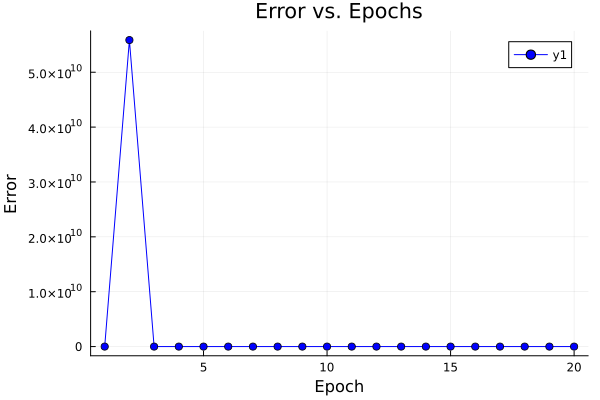

In [44]:
# Plot
plot(training_data.epoch, training_data.error, marker = :circle, linestyle = :solid, color = :blue, xlabel = "Epoch", ylabel = "Error", title = "Error vs. Epochs", grid = true)
